In [1]:
import pandas as pd
import numpy as np


# Load smaller tables directly
patients = pd.read_csv('PATIENTS.csv',nrows=1000,low_memory=False)
admissions = pd.read_csv('ADMISSIONS.csv',nrows=1000,low_memory=False)
diagnoses = pd.read_csv('DIAGNOSES_ICD.csv',nrows=1000,low_memory=False)
prescriptions = pd.read_csv('PRESCRIPTIONS.csv',nrows=1000,low_memory=False)

In [2]:
# For large tables, load selectively or in chunks
# Loading NOTEEVENTS.csv with selected columns and filtering
use_cols_notes = ['SUBJECT_ID', 'HADM_ID', 'CHARTTIME', 'CATEGORY', 'TEXT']
noteevents_iter = pd.read_csv('NOTEEVENTS.csv', usecols=use_cols_notes, chunksize=10000, low_memory=False)

In [6]:
# Filter notes to relevant categories while reading in chunks
notes_list = []
for chunk in noteevents_iter:
    filtered_chunk = chunk[chunk['CATEGORY'].isin(['Discharge summary', 'Nursing', 'Physician '])]
    notes_list.append(filtered_chunk)
noteevents = pd.concat(notes_list, ignore_index=True)

In [4]:
# Define lab item IDs relevant to mental health (e.g., toxicology screens)
relevant_item_ids = [50815, 50816]  # Example item IDs

labevents_iter = pd.read_csv('LABEVENTS.csv', chunksize=1000, low_memory=False)
labevents_list = []
for chunk in labevents_iter:
    filtered_chunk = chunk[chunk['ITEMID'].isin(relevant_item_ids)]
    labevents_list.append(filtered_chunk)
labevents = pd.concat(labevents_list, ignore_index=True)


In [7]:
diag_adm = pd.merge(diagnoses, admissions, on=['SUBJECT_ID', 'HADM_ID'], how='inner')
presc_adm = pd.merge(prescriptions, admissions, on=['SUBJECT_ID', 'HADM_ID'], how='inner')
notes_adm = pd.merge(noteevents, admissions, on=['SUBJECT_ID', 'HADM_ID'], how='inner')

# Merge all data
data = diag_adm.merge(presc_adm, on=['SUBJECT_ID', 'HADM_ID'], how='outer', suffixes=('_diag', '_presc'))
data = data.merge(notes_adm, on=['SUBJECT_ID', 'HADM_ID'], how='outer')
data = data.merge(patients, on='SUBJECT_ID', how='left')

In [8]:
# Drop rows where critical information is missing
data = data.dropna(subset=['ICD9_CODE', 'DRUG', 'TEXT'])


In [9]:
# Define mental health ICD-9 codes
mental_health_codes = ['296', '300', '309.81', '311', '295', '303', '304', '305', 'E95']

# Create binary feature indicating mental health diagnosis
data['MENTAL_HEALTH_DIAG'] = data['ICD9_CODE'].astype(str).str.startswith(tuple(mental_health_codes)).astype(int)


In [10]:
# List of mental health medications (lowercased)
mental_health_meds = ['fluoxetine', 'sertraline', 'citalopram', 'escitalopram', 'paroxetine', 'bupropion', 'venlafaxine', 'duloxetine', 'quetiapine', 'risperidone', 'lorazepam', 'diazepam']

# Normalize drug names to lowercase
data['DRUG'] = data['DRUG'].str.lower()

# Create binary feature for mental health medications
data['MENTAL_HEALTH_MED'] = data['DRUG'].str.contains('|'.join(mental_health_meds), na=False).astype(int)


In [11]:
# Convert date columns to datetime
data['ADMITTIME'] = pd.to_datetime(data['ADMITTIME'])
data['DOB'] = pd.to_datetime(data['DOB'])

# Calculate age at admission
data['AGE'] = data['ADMITTIME'].dt.year - data['DOB'].dt.year

# Correct ages over 89 due to de-identification
data.loc[data['AGE'] > 89, 'AGE'] = 90

# Encode gender
data['GENDER'] = data['GENDER'].map({'M': 0, 'F': 1})


In [12]:
# Group notes by admission
notes_grouped = notes_adm.groupby(['SUBJECT_ID', 'HADM_ID'])['TEXT'].apply(' '.join).reset_index()


In [13]:
notes_grouped.head()

,SUBJECT_ID,HADM_ID,TEXT
0,3,145834.0,Admission Date: [**2101-10-20**] Discharg...
1,4,185777.0,Admission Date: [**2191-3-16**] Discharge...
2,6,107064.0,Admission Date: [**2175-5-30**] Dischar...
3,9,150750.0,Admission Date: [**2149-11-9**] Dischar...
4,10,184167.0,Admission Date: [**2103-6-28**] Dischar...


In [14]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/maziyarmirzaei/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
sia = SentimentIntensityAnalyzer()

In [16]:
from tqdm import tqdm
# Compute sentiment scores
tqdm.pandas()  # Enable progress bar
notes_grouped['SENTIMENT'] = notes_grouped['TEXT'].progress_apply(lambda x: sia.polarity_scores(x)['compound'])

100%|█████████████████████████████████████████████| 868/868 [00:32<00:00, 26.81it/s]


In [17]:
# Define risk-related terms
risk_terms = ['suicidal', 'suicide', 'self-harm', 'hopelessness', 'overdose']

# Function to check for risk terms
def check_risk_terms(text):
    text = str(text).lower()
    return any(term in text for term in risk_terms)

# Apply function to notes
notes_grouped['RISK_TERM_PRESENT'] = notes_grouped['TEXT'].apply(check_risk_terms).astype(int)


In [18]:
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm
import numpy as np

# Initialize BERT components
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

# Function to get embeddings
def get_embedding(text):
    try:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state[:, 0, :].detach().numpy().squeeze()
    except Exception:
        # Return a zero vector if any error occurs
        return np.zeros(model.config.hidden_size)

# Generate embeddings for all notes
tqdm.pandas()  # Enable progress bar
notes_grouped['EMBEDDING'] = notes_grouped['TEXT'].progress_apply(get_embedding)


100%|█████████████████████████████████████████████| 868/868 [01:44<00:00,  8.33it/s]


In [19]:
# High risk if ICD-9 codes indicate self-harm or if risk terms are present in notes
data['SUICIDE_RISK'] = ((data['ICD9_CODE'].astype(str).str.startswith('E95')) | (notes_grouped['RISK_TERM_PRESENT'] == 1)).astype(int)


In [20]:
data = data.merge(
    notes_grouped[['SUBJECT_ID', 'HADM_ID', 'SENTIMENT', 'RISK_TERM_PRESENT', 'EMBEDDING']],
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'
)


In [21]:
embedding_size = model.config.hidden_size  # Typically 768 for BERT
data['EMBEDDING'] = data['EMBEDDING'].apply(
    lambda x: x if isinstance(x, np.ndarray) else np.zeros(embedding_size)
)


In [22]:
data = data.dropna(subset=['EMBEDDING'])


In [23]:
data.head()

,ROW_ID_x_diag,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,ROW_ID_y_diag,ADMITTIME_diag,DISCHTIME_diag,DEATHTIME_diag,ADMISSION_TYPE_diag,...,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,MENTAL_HEALTH_DIAG,MENTAL_HEALTH_MED,AGE,SUICIDE_RISK,SENTIMENT,RISK_TERM_PRESENT,EMBEDDING
0,13.0,4,185777.0,1.0,042,3.0,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,...,NaN,NaN,0.0,0,0,48,0,0.6638,0,"[-0.5105862, -0.24787569, -0.0339513, -0.64600..."
1,13.0,4,185777.0,1.0,042,3.0,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,...,NaN,NaN,0.0,0,0,48,0,0.6638,0,"[-0.5105862, -0.24787569, -0.0339513, -0.64600..."
2,13.0,4,185777.0,1.0,042,3.0,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,...,NaN,NaN,0.0,0,0,48,0,0.6638,0,"[-0.5105862, -0.24787569, -0.0339513, -0.64600..."
3,13.0,4,185777.0,1.0,042,3.0,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,...,NaN,NaN,0.0,0,0,48,0,0.6638,0,"[-0.5105862, -0.24787569, -0.0339513, -0.64600..."
4,13.0,4,185777.0,1.0,042,3.0,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,...,NaN,NaN,0.0,0,0,48,0,0.6638,0,"[-0.5105862, -0.24787569, -0.0339513, -0.64600..."


In [24]:
# Extract embedding vectors into a separate DataFrame
embeddings = pd.DataFrame(data['EMBEDDING'].tolist())
embeddings.columns = [f'embedding_{i}' for i in range(embeddings.shape[1])]

# Combine embeddings with other features
feature_columns = ['MENTAL_HEALTH_DIAG', 'MENTAL_HEALTH_MED', 'AGE', 'GENDER', 'SENTIMENT', 'RISK_TERM_PRESENT']
X = pd.concat([data[feature_columns].reset_index(drop=True), embeddings.reset_index(drop=True)], axis=1)

# Define target variable
y = data['SUICIDE_RISK']


In [27]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X.fillna(0), y)


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [29]:
from sklearn.metrics import classification_report, roc_auc_score

# Predictions
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_proba)
print(f'ROC-AUC Score: {roc_auc:.2f}')


              precision    recall  f1-score   support

           0       1.00      0.83      0.91      1912
           1       0.85      1.00      0.92      1882

    accuracy                           0.92      3794
   macro avg       0.93      0.92      0.92      3794
weighted avg       0.93      0.92      0.92      3794

ROC-AUC Score: 0.94


### SHAP Analysis:

In [30]:
import shap

# Take a sample of 100 instances from X_test
X_test_sample = X_test.sample(n=100, random_state=42)


In [31]:
explainer = shap.TreeExplainer(rf_model)

In [32]:
shap_values = explainer.shap_values(X_test_sample)

In [33]:
# Correct shape if needed
shap_values_corrected = shap_values[1].T if shap_values[1].shape[0] == X_test_sample.shape[1] else shap_values[1]

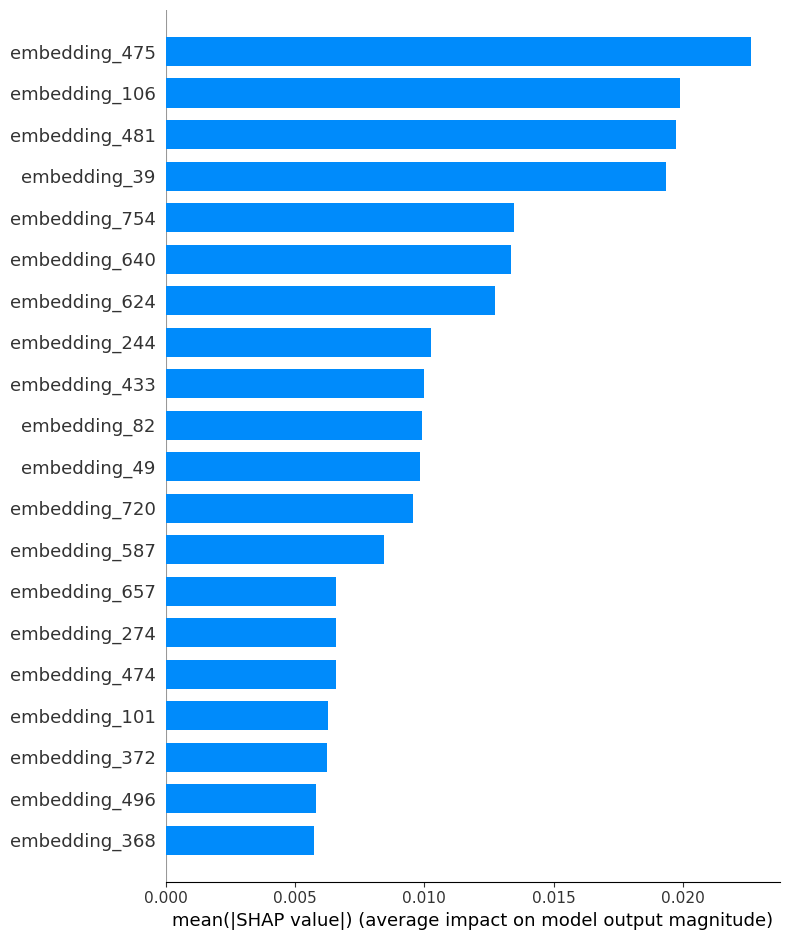

In [34]:
shap.summary_plot(shap_values_corrected, X_test_sample, plot_type='bar')


In [36]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from lime import lime_tabular

# Align columns between X_train and X_test
X_test = X_test[X_train.columns]

# Add missing columns in X_test if necessary
missing_cols = set(X_train.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0  # Or another default value

# Ensure column alignment
X_test = X_test[X_train.columns]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

# Initialize LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled.values,
    feature_names=X_train.columns.tolist(),
    class_names=['No Risk', 'High Risk'],
    mode='classification'
)

# Wrapper function to handle feature names
def predict_proba_with_feature_names(data):
    # Convert NumPy array to DataFrame with original feature names
    data_df = pd.DataFrame(data, columns=X_train.columns)
    return rf_model.predict_proba(data_df)

# Select an instance to explain
i = 42
instance = X_test_scaled.iloc[i]

# Explain the instance
exp = explainer.explain_instance(
    data_row=instance.values,  # Pass instance as NumPy array
    predict_fn=predict_proba_with_feature_names,  # Use wrapped function
    num_features=10
)

# Display explanation
exp.show_in_notebook(show_table=True)


In [37]:
from sklearn.metrics import classification_report

# Map gender encoding back to labels if necessary
gender_map = {0: 'M', 1: 'F'}

# Loop over genders
for gender in [0, 1]:
    idx = X_test['GENDER'] == gender
    y_true_gender = y_test[idx]
    y_pred_gender = y_pred[idx]
    print(f"Performance for Gender {gender_map[gender]}:")
    print(classification_report(y_true_gender, y_pred_gender))


Performance for Gender M:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1170

    accuracy                           1.00      1170
   macro avg       1.00      1.00      1.00      1170
weighted avg       1.00      1.00      1.00      1170

Performance for Gender F:
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       742
           1       0.85      1.00      0.92      1882

    accuracy                           0.88      2624
   macro avg       0.93      0.78      0.82      2624
weighted avg       0.90      0.88      0.87      2624



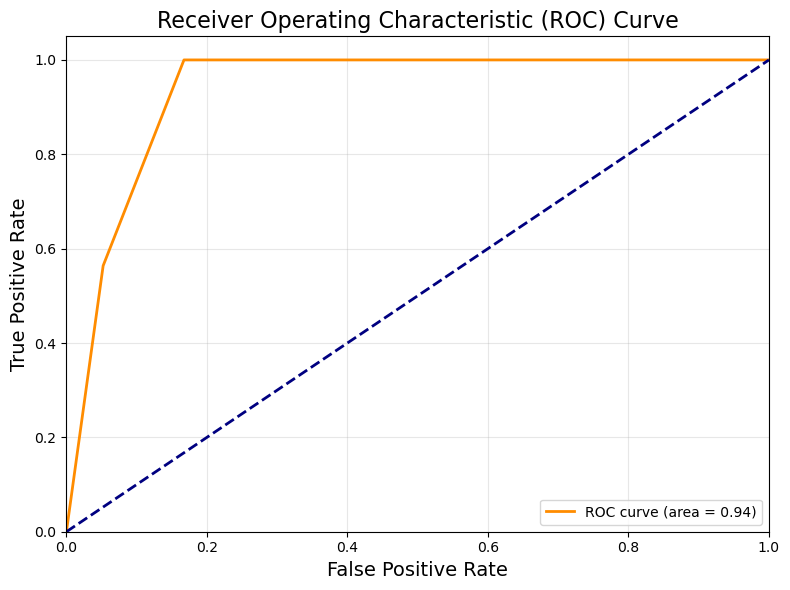

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for the model
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png')
plt.show()


<Figure size 1000x600 with 0 Axes>

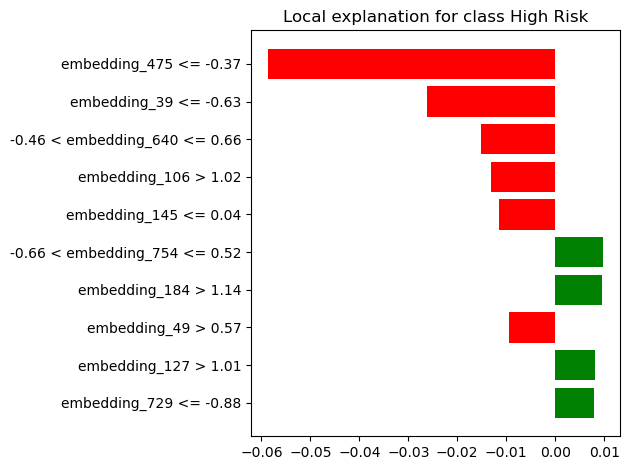

In [45]:
import lime
import lime.lime_tabular

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled.values,
    feature_names=X_train.columns.tolist(),
    class_names=['No Risk', 'High Risk'],
    mode='classification'
)

# Select an instance to explain
i = 42
instance = X_test_scaled.iloc[i]

# Explain the instance
exp = explainer.explain_instance(
    data_row=instance.values,
    predict_fn=predict_proba_with_feature_names,
    num_features=10
)

# Plot LIME explanation
plt.figure(figsize=(10, 6))
exp.as_pyplot_figure()
plt.tight_layout()
plt.savefig('lime_explanation_instance42.png')
plt.show()


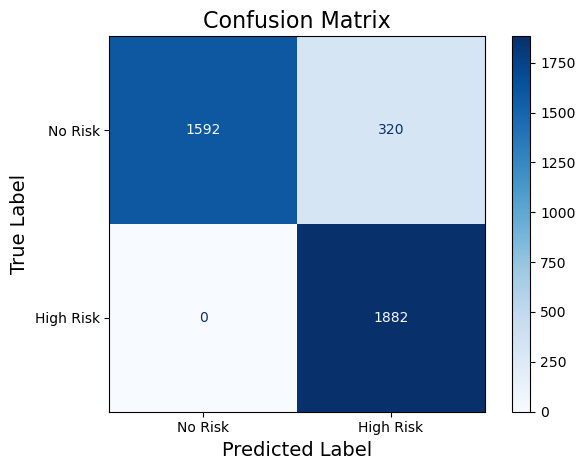

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Risk', 'High Risk'])

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()


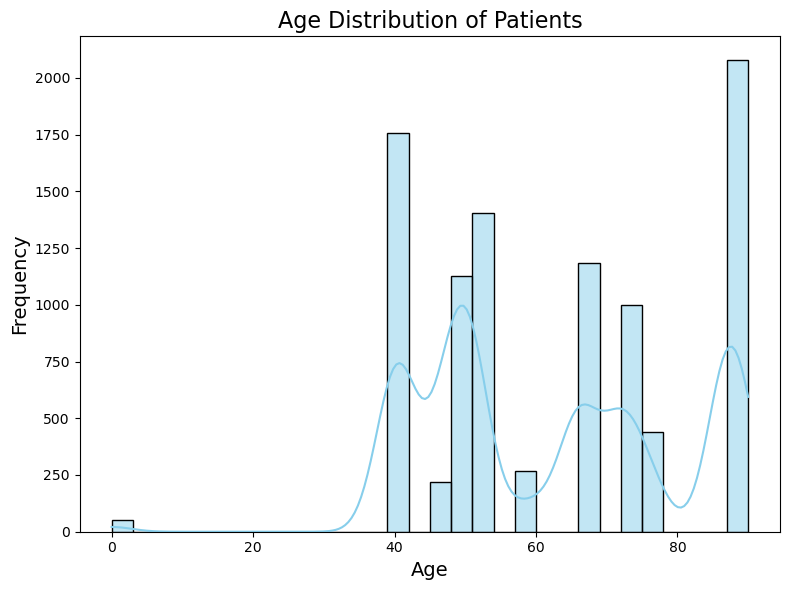

In [47]:
import seaborn as sns

# Plot age distribution
plt.figure(figsize=(8, 6))
sns.histplot(data['AGE'], bins=30, kde=True, color='skyblue')
plt.title('Age Distribution of Patients', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.tight_layout()
plt.savefig('age_distribution.png')
plt.show()
